In [3]:
# =============================================================================
# 1. IMPORT LIBRARIES
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 2. DATA PREPARATION FOR CIFAR-10
# =============================================================================

# Define a sequence of transformations to apply to the images.
# transforms.ToTensor() converts images to PyTorch Tensors.
# transforms.Normalize() adjusts the pixel values to a range of [-1, 1],
# which helps the network train more effectively.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the batch size for training and testing.
# The network will process images in groups of this size.
batch_size = 4

# Load the CIFAR-10 training dataset.
# The 'transform' is applied to each image as it's loaded.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 testing dataset.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the class names for the CIFAR-10 dataset.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# =============================================================================
# 3. DEFINE THE CONVOLUTIONAL NEURAL NETWORK (CNN)
# =============================================================================

# Define the network architecture by creating a class that inherits from nn.Module.
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer: takes 3-channel (RGB) images, produces 6 feature maps with a 5x5 kernel.
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling layer: downsamples feature maps using a 2x2 window.
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: takes 6 feature maps, produces 16 maps with a 5x5 kernel.
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers: transition from feature maps to a flat vector for classification.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input features are 16 maps of 5x5 pixels
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # Output layer with 10 units for the 10 classes.

    # The 'forward' method defines the path data takes through the network.
    def forward(self, x):
        # Apply conv1 -> ReLU activation -> pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply conv2 -> ReLU activation -> pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output from the convolutional layers to a 1D vector for the fully connected layers.
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # Apply fc1 -> GELU activation
        x = F.gelu(self.fc1(x))
        # Apply fc2 -> GELU activation
        x = F.gelu(self.fc2(x))
        # Final output layer (logits)
        x = self.fc3(x)
        return x

# Create an instance of the network.
net = Net()

# =============================================================================
# 4. DEFINE LOSS FUNCTION AND OPTIMIZER
# =============================================================================

# CrossEntropyLoss is well-suited for multi-class classification problems.
criterion = nn.CrossEntropyLoss()
# The Adam optimizer is an efficient algorithm for updating network weights.
# 'net.parameters()' tells the optimizer which parameters to update.
# 'lr' is the learning rate, which controls the step size of the updates.
optimizer = optim.Adam(net.parameters(), lr=0.001)

# =============================================================================
# 5. TRAIN THE NETWORK
# =============================================================================

print("Starting training...")
# Loop over the dataset multiple times (epochs).
for epoch in range(6):
    running_loss = 0.0
    # Loop over the data in batches.
    for i, data in enumerate(trainloader, 0):
        # Get inputs and their true labels from the data loader.
        inputs, labels = data

        # IMPORTANT: Zero the gradients from the previous step.
        optimizer.zero_grad()

        # Perform the main training cycle: forward pass + backward pass + optimization.
        outputs = net(inputs)              # Forward pass: get predictions.
        loss = criterion(outputs, labels)  # Calculate the loss (error).
        loss.backward()                    # Backward pass: compute gradients.
        optimizer.step()                   # Update the network's weights.

        # Print statistics to monitor training progress.
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


# =============================================================================
# 6. MANUAL 2D CONVOLUTION IMPLEMENTATION (for understanding)
# =============================================================================
print("\n--- Manual vs. PyTorch Convolution Example ---")

def conv2d_manual(input_matrix, kernel_matrix, padding=0, stride=1):
    """
    Performs a 2D convolution operation on a 2D numpy array.
    """
    # Extract dimensions
    input_height, input_width = input_matrix.shape
    kernel_height, kernel_width = kernel_matrix.shape

    # Calculate output dimensions based on padding and stride
    output_height = (input_height - kernel_height + 2 * padding) // stride + 1
    output_width = (input_width - kernel_width + 2 * padding) // stride + 1

    # Apply padding to the input if needed
    if padding > 0:
        padded_input = np.zeros((input_height + 2 * padding, input_width + 2 * padding))
        padded_input[padding:padding + input_height, padding:padding + input_width] = input_matrix
    else:
        padded_input = input_matrix

    # Initialize the output matrix
    output = np.zeros((output_height, output_width))

    # Perform the convolution by sliding the kernel over the padded input
    for y in range(output_height):
        for x in range(output_width):
            # Define the current region of interest
            _y = y * stride
            _x = x * stride
            region = padded_input[_y : _y + kernel_height, _x : _x + kernel_width]
            # Perform element-wise multiplication and sum the result
            output[y, x] = np.sum(region * kernel_matrix)

    return output

# --- Example Usage of Manual and PyTorch Conv2D ---

# Define a sample input matrix and kernel
input_matrix = np.array([
    [1, 2, 3, 0, 0],
    [4, 5, 6, 0, 0],
    [7, 8, 9, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=np.float32)

kernel_matrix = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
], dtype=np.float32)

# --- Manual Convolution ---
output_manual = conv2d_manual(input_matrix, kernel_matrix, padding=1, stride=2)
print("Manual conv2d output:")
print(output_manual)

# --- PyTorch Convolution (for comparison) ---
# Convert numpy arrays to PyTorch tensors and add batch and channel dimensions
input_tensor = torch.from_numpy(input_matrix).unsqueeze(0).unsqueeze(0)
kernel_tensor = torch.from_numpy(kernel_matrix).unsqueeze(0).unsqueeze(0)

# Define the conv2d operation in PyTorch with the same parameters
conv_pytorch = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=2, bias=False)
# Manually set the convolution weight to our kernel
conv_pytorch.weight.data = kernel_tensor

# Perform the convolution and convert the output back to a numpy array
output_tensor_pytorch = conv_pytorch(input_tensor)
output_pytorch = output_tensor_pytorch.squeeze().detach().numpy()

print("\nPyTorch conv2d output:")
print(output_pytorch)


Starting training...
[1,  2000] loss: 1.832
[1,  4000] loss: 1.591
[1,  6000] loss: 1.522
[1,  8000] loss: 1.469
[1, 10000] loss: 1.385
[1, 12000] loss: 1.367
[2,  2000] loss: 1.287
[2,  4000] loss: 1.293
[2,  6000] loss: 1.277
[2,  8000] loss: 1.269
[2, 10000] loss: 1.265
[2, 12000] loss: 1.240
[3,  2000] loss: 1.160
[3,  4000] loss: 1.160
[3,  6000] loss: 1.173
[3,  8000] loss: 1.185
[3, 10000] loss: 1.171
[3, 12000] loss: 1.150
[4,  2000] loss: 1.077
[4,  4000] loss: 1.064
[4,  6000] loss: 1.088
[4,  8000] loss: 1.105
[4, 10000] loss: 1.109
[4, 12000] loss: 1.108
[5,  2000] loss: 1.009
[5,  4000] loss: 1.027
[5,  6000] loss: 1.045
[5,  8000] loss: 1.018
[5, 10000] loss: 1.048
[5, 12000] loss: 1.075
[6,  2000] loss: 0.968
[6,  4000] loss: 0.961
[6,  6000] loss: 1.003
[6,  8000] loss: 1.006
[6, 10000] loss: 1.003
[6, 12000] loss: 1.028
Finished Training

--- Manual vs. PyTorch Convolution Example ---
Manual conv2d output:
[[ -7.   7.   0.]
 [-13.  13.   0.]
 [  0.   0.   0.]]

PyTorch

Starting training...
[1,  2000] loss: 1.859
[1,  4000] loss: 1.589
[1,  6000] loss: 1.501
[1,  8000] loss: 1.431
[1, 10000] loss: 1.407
[1, 12000] loss: 1.359
[2,  2000] loss: 1.288
[2,  4000] loss: 1.288
[2,  6000] loss: 1.265
[2,  8000] loss: 1.250
[2, 10000] loss: 1.233
[2, 12000] loss: 1.245
[3,  2000] loss: 1.153
[3,  4000] loss: 1.167
[3,  6000] loss: 1.152
[3,  8000] loss: 1.157
[3, 10000] loss: 1.178
[3, 12000] loss: 1.177
[4,  2000] loss: 1.082
[4,  4000] loss: 1.085
[4,  6000] loss: 1.093
[4,  8000] loss: 1.100
[4, 10000] loss: 1.113
[4, 12000] loss: 1.118
[5,  2000] loss: 1.019
[5,  4000] loss: 1.023
[5,  6000] loss: 1.028
[5,  8000] loss: 1.058
[5, 10000] loss: 1.075
[5, 12000] loss: 1.100
[6,  2000] loss: 0.980
[6,  4000] loss: 0.969
[6,  6000] loss: 1.008
[6,  8000] loss: 1.024
[6, 10000] loss: 1.032
[6, 12000] loss: 1.035
Finished Training

Evaluating network on test data...
Accuracy of the network on the 10000 test images: 58.48 %


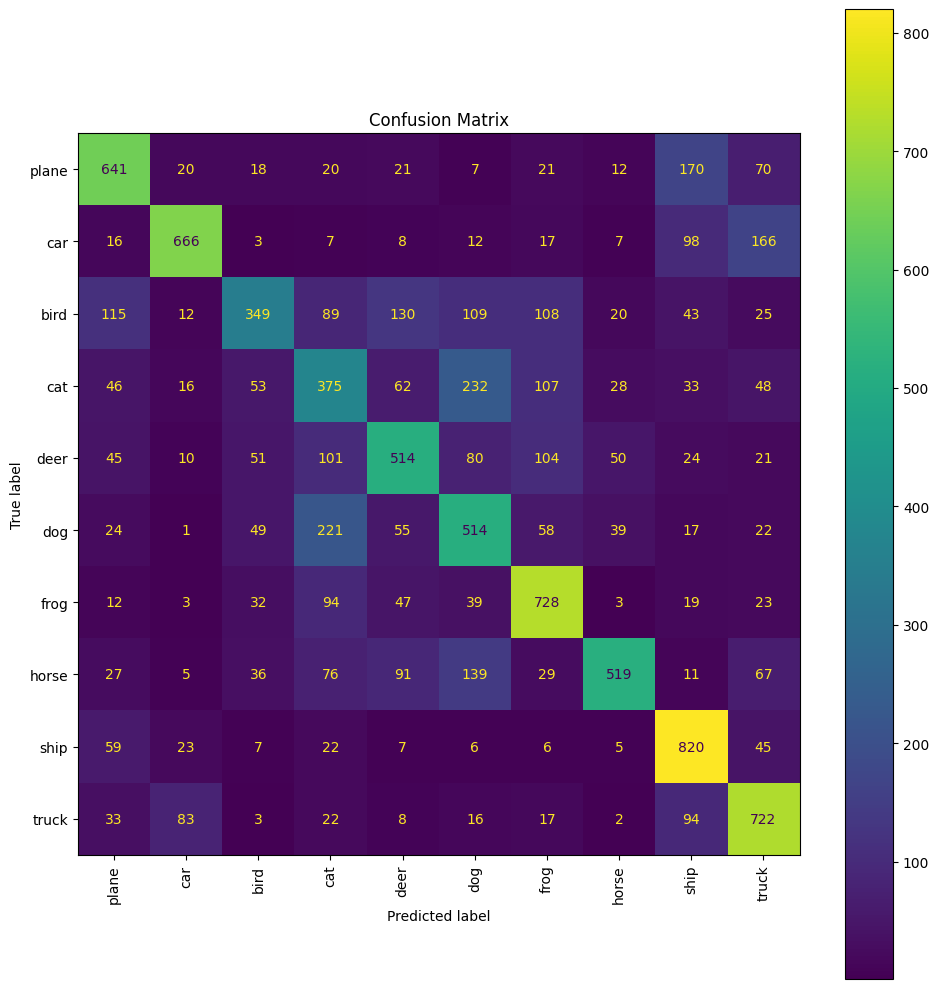

In [5]:
# =============================================================================
# 1. IMPORT LIBRARIES
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =============================================================================
# 2. DATA PREPARATION FOR CIFAR-10
# =============================================================================

# Define transformations to convert images to Tensors and normalize them.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Load the CIFAR-10 training and test datasets.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the class names.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# =============================================================================
# 3. DEFINE THE CONVOLUTIONAL NEURAL NETWORK (CNN)
# =============================================================================

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# =============================================================================
# 4. DEFINE LOSS FUNCTION AND OPTIMIZER
# =============================================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# =============================================================================
# 5. TRAIN THE NETWORK
# =============================================================================

print("Starting training...")
for epoch in range(6):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Finished Training')

# =============================================================================
# 6. EVALUATE THE NETWORK ON TEST DATA
# =============================================================================
print("\nEvaluating network on test data...")

# Prepare to collect predictions and true labels
all_preds = []
all_labels = []

# Set the model to evaluation mode. This is important for layers like dropout.
net.eval()

# We don't need to calculate gradients during evaluation, so we use no_grad
# to make it more memory-efficient.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # Forward pass to get outputs (logits)
        outputs = net(images)
        
        # Get the predicted class by finding the index of the highest logit
        _, predicted = torch.max(outputs.data, 1)
        
        # Append batch predictions and labels to our lists
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate overall accuracy
correct = (np.array(all_preds) == np.array(all_labels)).sum()
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')


# --- Generate and Display the Confusion Matrix ---

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using Scikit-learn's display object
# This provides a clean and readable visualization.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
